# Predictive Maintenance - Activity 1 NS4IOT
# Network Solutions for IoT
# Albert Marquillas - September, 2025
# Group B - Eric Ramirez & Jordi Nadeu

## Objectives

The purpose of this practical session is to explore predictive maintenance using machine learning
techniques, specifically through the analysis of sensor data from industrial machinery. Students
will apply exploratory data analysis (EDA), correlation analysis, and build predictive models
using K-Nearest Neighbors (KNN) and Support Vector Machines (SVM).


In [416]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [417]:
# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

# Download and load dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shivamb/machine-predictive-maintenance-classification")
print("Path to dataset files:", path)


Using Colab cache for faster access to the 'machine-predictive-maintenance-classification' dataset.
Path to dataset files: /kaggle/input/machine-predictive-maintenance-classification


In [418]:
# Load the dataset
import os
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
print("Available CSV files:", csv_files)

Available CSV files: ['predictive_maintenance.csv']


In [419]:
# Load the predictive maintenance dataset
df = pd.read_csv(os.path.join(path, 'predictive_maintenance.csv'))
print("Dataset loaded successfully!")


Dataset loaded successfully!


## 4.1. Initial Data Exploration (EDA)


In [420]:
print("=" * 50)
print("INITIAL DATA EXPLORATION")
print("=" * 50)

# Display basic information about the dataset

print("\nFirst 5 rows:")
print(df.head(5))

print("\nSummary Statistics:")
print(df.describe())


INITIAL DATA EXPLORATION

First 5 rows:
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure  

Summary Statistics:
               UDI  Air temperat

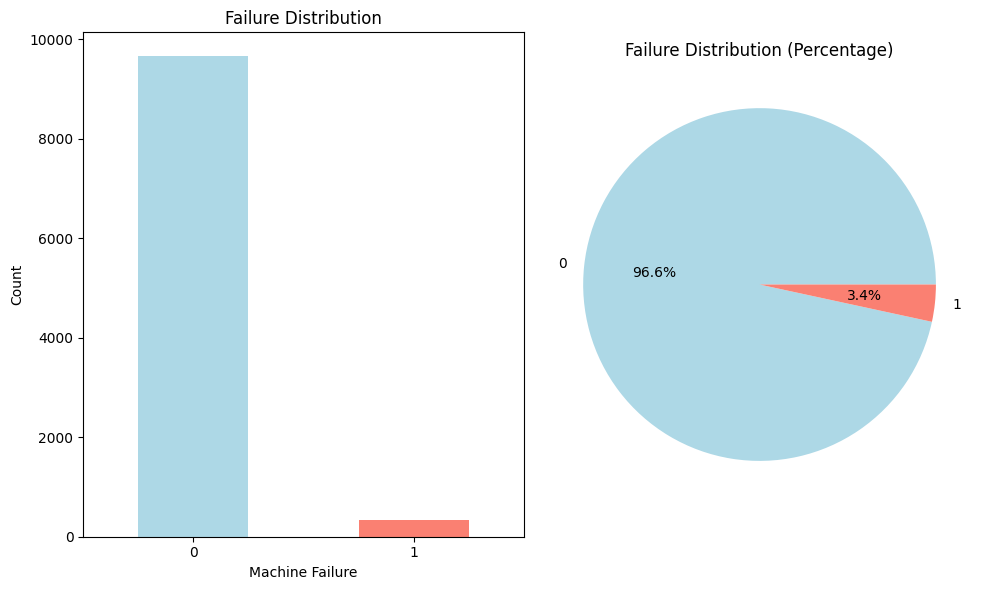

In [421]:
# Visualize class distribution

target_col = 'Target'

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
df[target_col].value_counts().plot(kind='bar', color=['lightblue', 'salmon'])
plt.title('Failure Distribution')
plt.xlabel('Machine Failure')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
df[target_col].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'salmon'])
plt.title('Failure Distribution (Percentage)')
plt.ylabel('')

plt.tight_layout()
plt.show()

### Discussion about dataset balance

The dataset is very unbalanced because there are many more no failures. In fact, the vast majority of the dataset consists of no failures, almost the 97% of the events.

## 4.2. Correlation Analysis



CORRELATION ANALYSIS


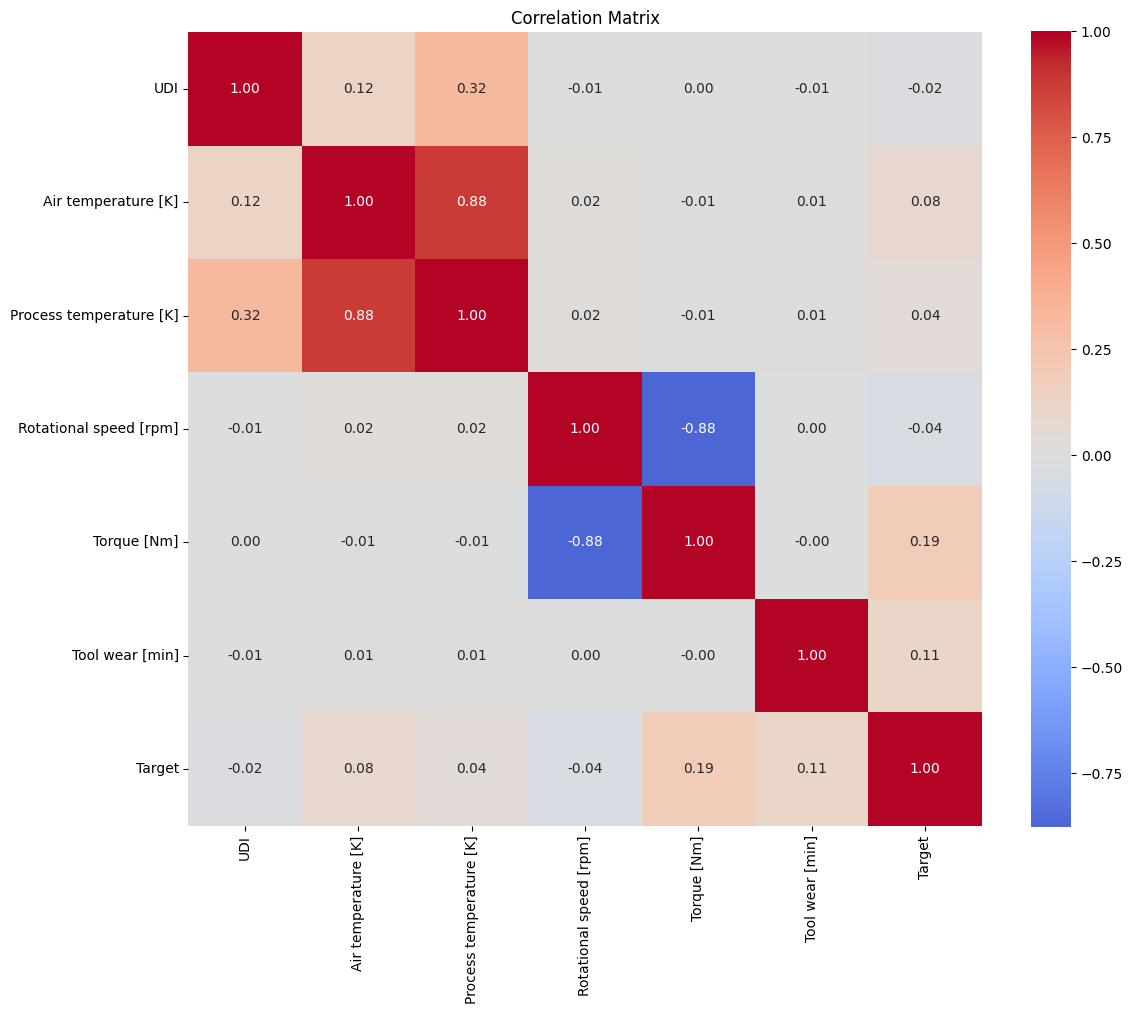

In [422]:
print("\n" + "=" * 50)
print("CORRELATION ANALYSIS")
print("=" * 50)

# Select only numeric columns for correlation analysis
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Compute correlation matrix
corr_matrix = df[numeric_cols].corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [423]:
# Identify features most correlated with target
target_corr = corr_matrix[target_col].abs().sort_values(ascending=False)
print(f"Top features correlated with machine failure:")
top_features = target_corr.drop(target_col).head(3)
for feature, corr_value in top_features.items():
    print(f"   {feature}: {corr_value:.3f}")

Top features correlated with machine failure:
   Torque [Nm]: 0.191
   Tool wear [min]: 0.105
   Air temperature [K]: 0.083


## 4.3. Data Preparation

In [424]:
print("\n" + "=" * 50)
print("DATA PREPARATION")
print("=" * 50)

# Prepare features and target
cols_to_drop = []
for col in df.columns:
    if df[col].dtype == 'object' and col != target_col:
        if col not in ['Type']:  # Keep 'Type' if it exists, we'll encode it
            cols_to_drop.append(col)

print(f"Columns to drop: {cols_to_drop}")


DATA PREPARATION
Columns to drop: ['Product ID', 'Failure Type']


In [425]:
# Since we know 'Type' column exists, we can directly encode it
df_encoded = pd.get_dummies(df, columns=['Type'], prefix='Type')

# Drop non-useful columns
df_encoded = df_encoded.drop(columns=cols_to_drop, errors='ignore')

# Separate features and target
X = df_encoded.drop(target_col, axis=1)
y = df_encoded[target_col]

In [426]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")



Training set shape: (8000, 9)
Testing set shape: (2000, 9)


In [427]:
# Apply standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(" Data standardized successfully")

 Data standardized successfully


## 4.4. Classification with KNN

In [428]:
print("\n" + "=" * 50)
print("K-NEAREST NEIGHBORS CLASSIFICATION")
print("=" * 50)

# Train KNN classifier with k=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

# Evaluate KNN performance
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_precision = precision_score(y_test, y_pred_knn)
knn_recall = recall_score(y_test, y_pred_knn)
knn_f1 = f1_score(y_test, y_pred_knn)

print(f"KNN Results (k=5):")
print(f"   Accuracy:  {knn_accuracy:.4f}")
print(f"   Precision: {knn_precision:.4f}")
print(f"   Recall:    {knn_recall:.4f}")
print(f"   F1-Score:  {knn_f1:.4f}")


K-NEAREST NEIGHBORS CLASSIFICATION
KNN Results (k=5):
   Accuracy:  0.9735
   Precision: 0.8000
   Recall:    0.2941
   F1-Score:  0.4301



KNN Confusion Matrix:
[[1927    5]
 [  48   20]]


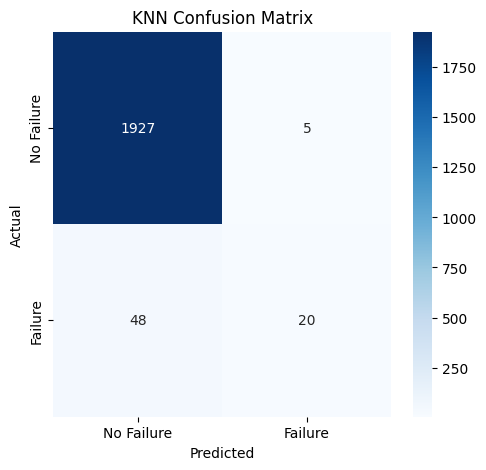

In [429]:
# Confusion Matrix
knn_cm = confusion_matrix(y_test, y_pred_knn)
print(f"\nKNN Confusion Matrix:")
print(knn_cm)

# Visualize confusion matrix
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Failure', 'Failure'],
            yticklabels=['No Failure', 'Failure'])
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [430]:
# Classification Report
print(f"\nKNN Classification Report:")
print(classification_report(y_test, y_pred_knn))


KNN Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1932
           1       0.80      0.29      0.43        68

    accuracy                           0.97      2000
   macro avg       0.89      0.65      0.71      2000
weighted avg       0.97      0.97      0.97      2000



In [438]:
# Try different values of k
print(f"\nTesting different k values:")
k_values = [1, 3, 5, 7, 9, 11, 15, 21]
k_scores = []

for k in k_values:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp.fit(X_train_scaled, y_train)
    y_pred_temp = knn_temp.predict(X_test_scaled)
    score = accuracy_score(y_test, y_pred_temp)
    f1 = f1_score(y_test, y_pred_temp)
    k_scores.append(score)
    print(f"   k ={k:2d}: Accuracy = {score:.4f}, F1-score = {f1:.4f}")


Testing different k values:
   k= 1: Accuracy = 0.9650 , F1-score = 0.4355
   k= 3: Accuracy = 0.9725 , F1-score = 0.4330
   k= 5: Accuracy = 0.9735 , F1-score = 0.4301
   k= 7: Accuracy = 0.9740 , F1-score = 0.4348
   k= 9: Accuracy = 0.9725 , F1-score = 0.3529
   k=11: Accuracy = 0.9710 , F1-score = 0.2927
   k=15: Accuracy = 0.9705 , F1-score = 0.2532
   k=21: Accuracy = 0.9675 , F1-score = 0.1333


Based on the testing done, the best k value are 7

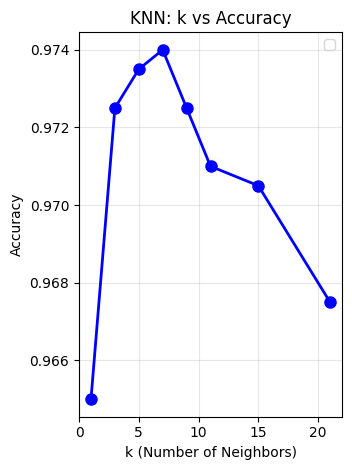

In [432]:
# Plot k vs accuracy
plt.subplot(1, 2, 2)
plt.plot(k_values, k_scores, 'bo-', linewidth=2, markersize=8)
plt.title('KNN: k vs Accuracy')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

## 4.5. Classification with SVM

In [433]:
print("\n" + "=" * 50)
print("SUPPORT VECTOR MACHINE CLASSIFICATION")
print("=" * 50)

# Train SVM classifier with RBF kernel
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)

# Evaluate SVM performance
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm)
svm_recall = recall_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm)

print(f"SVM Results (RBF kernel):")
print(f"   Accuracy:  {svm_accuracy:.4f}")
print(f"   Precision: {svm_precision:.4f}")
print(f"   Recall:    {svm_recall:.4f}")
print(f"   F1-Score:  {svm_f1:.4f}")


SUPPORT VECTOR MACHINE CLASSIFICATION
SVM Results (RBF kernel):
   Accuracy:  0.9705
   Precision: 0.8462
   Recall:    0.1618
   F1-Score:  0.2716



SVM Confusion Matrix:
[[1930    2]
 [  57   11]]


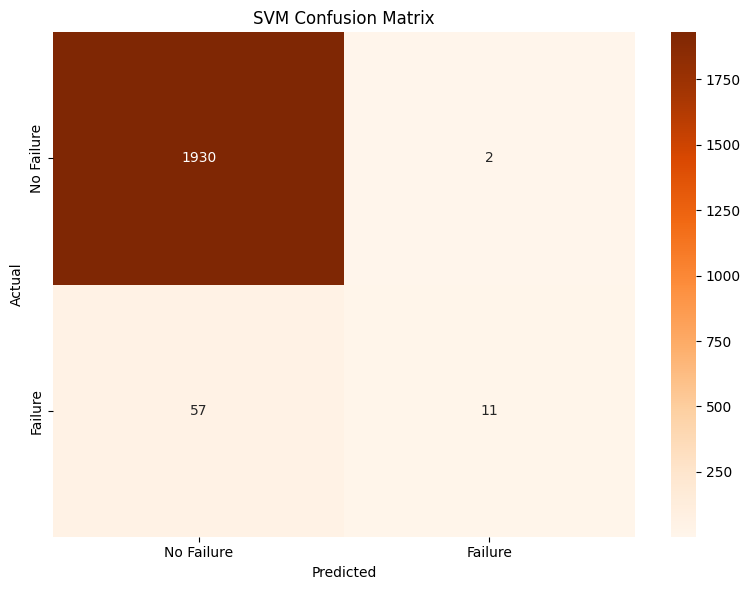

In [434]:
# Confusion Matrix
svm_cm = confusion_matrix(y_test, y_pred_svm)
print(f"\nSVM Confusion Matrix:")
print(svm_cm)

# Visualize SVM confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['No Failure', 'Failure'],
            yticklabels=['No Failure', 'Failure'])
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [435]:
# Classification Report
print(f"\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1932
           1       0.85      0.16      0.27        68

    accuracy                           0.97      2000
   macro avg       0.91      0.58      0.63      2000
weighted avg       0.97      0.97      0.96      2000



In [436]:
print("\n" + "=" * 50)
print("MODEL COMPARISON KNN vs SVM")
print("=" * 50)

# Create comparison dataframe
comparison_data = {
    'Model': ['KNN (k=5)', 'SVM (RBF)'], # Here we're considera the comparation with the optional extension part
    'Accuracy': [knn_accuracy, svm_accuracy],
    'Precision': [knn_precision, svm_precision],  # Will calculate best k precision
    'Recall': [knn_recall, svm_recall],         # Will calculate best k recall
    'F1-Score': [knn_f1, svm_f1]               # Will calculate best k f1
}

comparison_df = pd.DataFrame(comparison_data)
print("Model Performance Comparison:")
print(comparison_df.round(4))



MODEL COMPARISON KNN vs SVM
Model Performance Comparison:
       Model  Accuracy  Precision  Recall  F1-Score
0  KNN (k=5)    0.9735     0.8000  0.2941    0.4301
1  SVM (RBF)    0.9705     0.8462  0.1618    0.2716


## 5. Optional Extensions

In [437]:
print("\n" + "=" * 50)
print("OPTIONAL EXTENSIONS")
print("=" * 50)

#We already made try different values of k for KNN

# SMOTE for dataset balancing
print(f"\nApplying SMOTE to balance dataset")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"   Original training set: {y_train.value_counts().to_dict()}")
print(f"   SMOTE training set: {pd.Series(y_train_smote).value_counts().to_dict()}")

# Test models on SMOTE data
best_k = 7
knn_smote = KNeighborsClassifier(n_neighbors=best_k)
knn_smote.fit(X_train_smote, y_train_smote)
y_pred_knn_smote = knn_smote.predict(X_test_scaled)

svm_smote = SVC(kernel='rbf', random_state=42)
svm_smote.fit(X_train_smote, y_train_smote)
y_pred_svm_smote = svm_smote.predict(X_test_scaled)

print(f"   KNN with SMOTE - Accuracy: {accuracy_score(y_test, y_pred_knn_smote):.4f}, F1: {f1_score(y_test, y_pred_knn_smote):.4f}")
print(f"   SVM with SMOTE - Accuracy: {accuracy_score(y_test, y_pred_svm_smote):.4f}, F1: {f1_score(y_test, y_pred_svm_smote):.4f}")


OPTIONAL EXTENSIONS

Applying SMOTE to balance dataset
   Original training set: {0: 7729, 1: 271}
   SMOTE training set: {0: 7729, 1: 7729}
   KNN with SMOTE - Accuracy: 0.9245, F1: 0.4215
   SVM with SMOTE - Accuracy: 0.9160, F1: 0.4207



## 6. Conclusion and Questions

**6.1 Which model performed better? Why?**

KNN (best k=7) performed slightly better than SVM based on your results: Best Performing Model: KNN (best k=7)

    F1-Score: 0.4348
    Accuracy: 0.9740

Model Analysis:
   KNN performed better than SVM, possible reasons:
   
      - Local patterns in the data favor neighborhood-based decisions
      - The dataset might have simple decision boundaries
      - KNN adapts well to local data distribution

**6.2 What are the limitations of this dataset?**
   - Class imbalance: 96.6% vs 3.4%
   - Limited failure samples, only 339 failure cases out of 10,000 samples
   - Limited feature set - real industrial systems have many more sensors
   - Overfitting risk, small failure class size can lead to poor generalization
   - No temporal aspects considered (time series patterns)

**6.3 What kind of preprocessing or feature engineering could improve the models?**

Address Class Imbalance:

- SMOTE oversampling: Your low recall scores indicate the models need more failure examples
- Cost-sensitive learning: Penalize missed failures more heavily


Improve Failure Detection:

- Feature engineering: Create interaction terms (e.g. Torque vs Speed ratios)
- Threshold tuning: Optimize decision thresholds for better recall-precision balance


Model Improvements:

- Ensemble methods: Random Forest or XGBoost might better handle the imbalance
- Different kernels: Try polynomial or sigmoid kernels for SVM

